In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Features engineering
## Input: transactions dataset (name: transactions 2018)
## Output: dataset with features for profiling normalized (name: data)

In [2]:
df=pd.read_csv("transactions2018.csv")
df.head()

,index,Account_No,DATE,TRANSACTION_DETAILS,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,year,month,day,type,AMOUNT
0,0,409000611074',2018-01-01,INDO GIBL Indiaforensic STL31121,14000.0,0.0,697823.0,2018,1,1,PAYEMENT,14000.0
1,1,409000611074',2018-01-01,INDO GIBL Indiaforensic STL30121,54250.0,0.0,643573.0,2018,1,1,DEBIT,54250.0
2,2,409000611074',2018-01-02,INDO GIBL Indiaforensic STL01011,147500.0,0.0,496073.0,2018,1,2,PAYEMENT,147500.0
3,3,409000611074',2018-01-03,FDRL/INTERNAL FUND TRANSFE,0.0,500000.0,996073.0,2018,1,3,TRANSFER,500000.0
4,4,409000611074',2018-01-03,INDO GIBL Indiaforensic STL02011,323500.0,0.0,672573.0,2018,1,3,PAYEMENT,323500.0


In [3]:
clients=list(df['Account_No'].unique())

In [4]:
clients

["409000611074'",
 "409000493201'",
 "409000425051'",
 "409000405747'",
 "409000438611'",
 "409000493210'",
 "409000438620'",
 "1196711'",
 "1196428'",
 "409000362497'",
 'A',
 'B']

In [5]:
df=df[df['Account_No'].isin(["409000362497'", "1196428'","409000438611'","409000438620'"])]

In [6]:
#work on one month
df=df[df["month"]==1]

In [16]:
#Leave the withdrawal and deposit and drop amount
profiling_df=df.drop(["index","Account_No","TRANSACTION_DETAILS","AMOUNT", "year","type","month","day"], axis=1)

In [8]:
# profiling_df["DATE"] = pd.to_datetime(profiling_df['DATE'],format='%Y-%m-%d')
# profiling_df['month']=profiling_df['DATE'].dt.month 
# profiling_df['day']=profiling_df['DATE'].dt.day
# profiling_df['dayofweek']=profiling_df['DATE'].dt.dayofweek 
# profiling_df['quarter']=profiling_df['DATE'].dt.quarter


In [17]:
profiling_df=profiling_df.drop(["DATE"], axis=1)

In [18]:
profiling_df.head()

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
1283,0.0,416.00,267014.95
1284,0.0,888110.76,1155125.71
1285,0.0,989.00,1156114.71
1286,0.0,1636631.26,2792745.97
1287,0.0,1721285.90,4514031.87


In [19]:
profiling_df.skew()

WITHDRAWAL_AMT    5.943194
DEPOSIT_AMT       7.193201
BALANCE_AMT       0.078476
dtype: float64

In [20]:
profiling_df['WITHDRAWAL_AMT']=np.log(profiling_df['WITHDRAWAL_AMT']+1)
profiling_df['DEPOSIT_AMT']=np.log(profiling_df['DEPOSIT_AMT']+1)

In [21]:
profiling_df.skew()

WITHDRAWAL_AMT    0.034774
DEPOSIT_AMT       0.992909
BALANCE_AMT       0.078476
dtype: float64

In [22]:
#Standarize features values to apply clustering methods
def df_clustering_std(df_clustering):
    features=list(df_clustering.columns)
    x = df_clustering.loc[:, features].values
    #Standardizing the features
    x = StandardScaler().fit_transform(x)
    d=df_clustering
    d[features] =x
    return d

In [23]:
data=df_clustering_std(profiling_df)

In [24]:
data.head()

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
1283,-1.282418,0.309160,0.920372
1284,-1.282418,1.519493,0.929714
1285,-1.282418,0.445709,0.929724
1286,-1.282418,1.616035,0.946939
1287,-1.282418,1.623999,0.965045


# Clustering model
## Input: dataset data
## Output:  number of clusters (k)
## +  Centroids coordinates (centroids)
## + Cluster of each point (labels)

In [25]:
def plot_k(df_clustering_std):
    features=list(df_clustering_std.columns)
    X1 = df_clustering_std[features].iloc[: , :].values
    inertia = []
    for n in range(1 , 11):
        algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
        algorithm.fit(X1)
        inertia.append(algorithm.inertia_)

    #Selecting N Clusters based in Inertia (Squared Distance between Centroids and data points, should be less)
    plt.figure(1 , figsize = (10 ,6))
    plt.plot(np.arange(1 , 11) , inertia , 'o')
    plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    return plt.show()

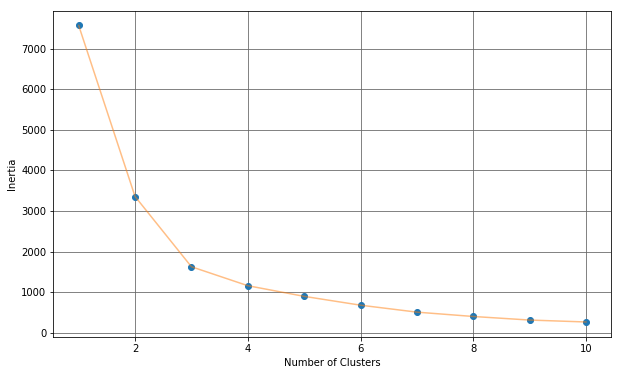

In [26]:
plot_k(data)

In [27]:
def kmeans(df_clustering_std,k):
    features=list(df_clustering_std.columns)
    algorithm = (KMeans(n_clusters = k ,init='k-means++', n_init = 10 ,max_iter=300, 
                            tol=0.0001,  random_state= 111  , algorithm='elkan') )
    X1 = df_clustering_std[features].iloc[: , :].values
    algorithm.fit(X1)
    labels = algorithm.labels_
    centroids = algorithm.cluster_centers_
    labelsncentroids=[labels,centroids]
    return labelsncentroids

In [28]:
k=3
labels=kmeans(data,3)[0]
centroids=kmeans(data,3)[1]

# Centroids table

In [29]:
centroids_table=pd.DataFrame()
centroids_table["profils"]=list(range(0,k))

In [30]:
data.head()

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
1283,-1.282418,0.309160,0.920372
1284,-1.282418,1.519493,0.929714
1285,-1.282418,0.445709,0.929724
1286,-1.282418,1.616035,0.946939
1287,-1.282418,1.623999,0.965045


In [32]:
# list(centroids)[0][2]

In [33]:
# list(centroids)

In [31]:
# ADD Centroids coordinates for each cluster (profile)
a=[]
for i in range(len(list(centroids))):
    a.append(list(centroids)[i][0])
centroids_table["WITHDRAWAL_AMT"]=a

b=[]
for i in range(len(list(centroids))):
    b.append(list(centroids)[i][1])
centroids_table["DEPOSIT_AMT"]=b

c=[]
for i in range(len(list(centroids))):
    c.append(list(centroids)[i][2])
centroids_table["BALANCE_AMT"]=c

# d=[]
# for i in range(len(list(centroids))):
#     d.append(list(centroids)[i][3])
# centroids_table["day_score"]=d

# e=[]
# for i in range(len(list(centroids))):
#     e.append(list(centroids)[i][4])
# centroids_table["dayofweek_score"]=e

# f=[]
# for i in range(len(list(centroids))):
#     f.append(list(centroids)[i][5])
# centroids_table["quarter_score"]=f

In [32]:
centroids_table

,profils,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
0,0,0.768345,-0.643641,-0.757158
1,1,-1.282418,1.485534,-0.130763
2,2,0.250718,-0.634116,1.190960


In [17]:
list(centroids)[0][0]

-0.031898789746013796

In [33]:
# add cluster number to each point in data and df
data["cluster"]=labels
df["cluster"]=labels

In [34]:
data["Account_No"]=df["Account_No"]

In [35]:
data.head(1)

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,cluster,Account_No
1283,-1.282418,0.30916,0.920372,1,409000438611'


# Scores computing
## Input: dataset data
##  Output: df with scores and sub-scores variables


### 1) Get cluster (profile) number for each client

In [36]:
clients=list(df["Account_No"].unique())

In [ ]:
# for acc in clients:
#     print(acc)
#     print(data[data["Account_No"]==acc]["cluster"].value_counts())

In [37]:
#add the variable cluster_max to dataset data

data['cluster_max']=0
for acc in clients:
    cond=data["Account_No"]==acc
    data['cluster_max']=data['cluster_max'].mask(cond, data[cond]["cluster"].value_counts().index[0])

In [38]:
data.head(1)

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,cluster,Account_No,cluster_max
1283,-1.282418,0.30916,0.920372,1,409000438611',1


In [39]:
centroids_table.head(1)

,profils,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT
0,0,0.768345,-0.643641,-0.757158


In [41]:
#add coordinates of centroids of cluster_max to dataset data:

data['bal_centroid']=0
data['withd_centroid']=0
data['deposit_centroid']=0
# data['day_centroid']=0
# data['dayofweek_centroid']=0
# data['quarter_centroid']=0


for i in range(len(centroids_table)):
    
    bal_centroid_0=centroids_table["BALANCE_AMT"][i]
    withd_centroid_0=centroids_table["WITHDRAWAL_AMT"][i]
    deposit_centroid_0=centroids_table["DEPOSIT_AMT"][i]
#     day_centroid_0=centroids_table["day_score"][i]
#     dayofweek_centroid_0=centroids_table["dayofweek_score"][i]
#     quarter_centroid_0=centroids_table["quarter_score"][i]
    
    cond=data["cluster_max"]==i
    
    data['bal_centroid']=data["bal_centroid"].mask(cond,bal_centroid_0)
    data['withd_centroid']=data["withd_centroid"].mask(cond,withd_centroid_0)
    data['deposit_centroid']=data["deposit_centroid"].mask(cond,deposit_centroid_0)
#     data['day_centroid']=data["day_centroid"].mask(cond,day_centroid_0)
#     data['dayofweek_centroid']=data["dayofweek_centroid"].mask(cond,dayofweek_centroid_0)
#     data['quarter_centroid']=data["quarter_centroid"].mask(cond,quarter_centroid_0)


In [42]:
data.head()

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,cluster,Account_No,cluster_max,bal_centroid,withd_centroid,deposit_centroid
1283,-1.282418,0.309160,0.920372,1,409000438611',1,-0.130763,-1.282418,1.485534
1284,-1.282418,1.519493,0.929714,1,409000438611',1,-0.130763,-1.282418,1.485534
1285,-1.282418,0.445709,0.929724,1,409000438611',1,-0.130763,-1.282418,1.485534
1286,-1.282418,1.616035,0.946939,1,409000438611',1,-0.130763,-1.282418,1.485534
1287,-1.282418,1.623999,0.965045,1,409000438611',1,-0.130763,-1.282418,1.485534


In [34]:
# centroids_table

### 2) Use the centroids of cluster_max to compute distance between points and centroid

In [43]:
data.head(1)

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,cluster,Account_No,cluster_max,bal_centroid,withd_centroid,deposit_centroid
1283,-1.282418,0.30916,0.920372,1,409000438611',1,-0.130763,-1.282418,1.485534


In [44]:
data["balance_score"]=np.abs(data["BALANCE_AMT"]- data["bal_centroid"])
data["withd_score"]=np.abs(data["WITHDRAWAL_AMT"]- data["withd_centroid"])
data["deposit_score"]=np.abs(data["DEPOSIT_AMT"]- data["deposit_centroid"])
# data["day_score"]=np.abs(data["day"]- data["day_centroid"])
# data["dayofweek_score"]=np.abs(data["dayofweek"]- data["dayofweek_centroid"])
# data["quarter_score"]=np.abs(data["quarter"]- data["quarter_centroid"])

data["transaction_score"]=data["balance_score"]+data["withd_score"]+data["deposit_score"]

In [45]:
data.head(1)

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,cluster,Account_No,cluster_max,bal_centroid,withd_centroid,deposit_centroid,balance_score,withd_score,deposit_score,transaction_score
1283,-1.282418,0.30916,0.920372,1,409000438611',1,-0.130763,-1.282418,1.485534,1.051135,1.088019e-14,1.176374,2.227509


In [46]:
# Add the variable "is_normal" THAT takes 1 if the transaction is normal according to the clustering (its cluster is the cluster_max ) and takes 0 if not
cond= data["cluster_max"]== data["cluster"]
data["is_normal"]=0
data["is_normal"]= data["is_normal"].mask(cond,1)

In [47]:
data.head()

,WITHDRAWAL_AMT,DEPOSIT_AMT,BALANCE_AMT,cluster,Account_No,cluster_max,bal_centroid,withd_centroid,deposit_centroid,balance_score,withd_score,deposit_score,transaction_score,is_normal
1283,-1.282418,0.309160,0.920372,1,409000438611',1,-0.130763,-1.282418,1.485534,1.051135,1.088019e-14,1.176374,2.227509,1
1284,-1.282418,1.519493,0.929714,1,409000438611',1,-0.130763,-1.282418,1.485534,1.060476,1.088019e-14,0.033959,1.094435,1
1285,-1.282418,0.445709,0.929724,1,409000438611',1,-0.130763,-1.282418,1.485534,1.060487,1.088019e-14,1.039825,2.100312,1
1286,-1.282418,1.616035,0.946939,1,409000438611',1,-0.130763,-1.282418,1.485534,1.077702,1.088019e-14,0.130501,1.208203,1
1287,-1.282418,1.623999,0.965045,1,409000438611',1,-0.130763,-1.282418,1.485534,1.095807,1.088019e-14,0.138465,1.234273,1


In [50]:
data[data["Account_No"]==clients[1]] ["is_normal"].value_counts()

1    703
0    108
Name: is_normal, dtype: int64

### 3) Add thresholds

In [51]:
profiles=list(data["cluster_max"].unique())

In [52]:
profiles

[1, 2, 0]

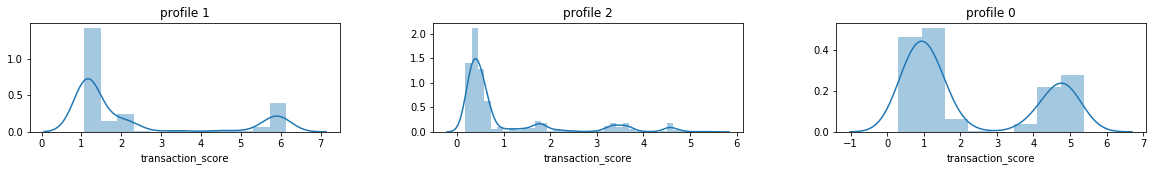

In [53]:
plt.figure(1 , figsize = (20 , 5))
n = 0 
for x in profiles:
    n += 1
    plt.subplot(2 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.distplot(data[data["cluster_max"]==x]["transaction_score"])

    plt.title( "profile " + str(x) )
plt.show()



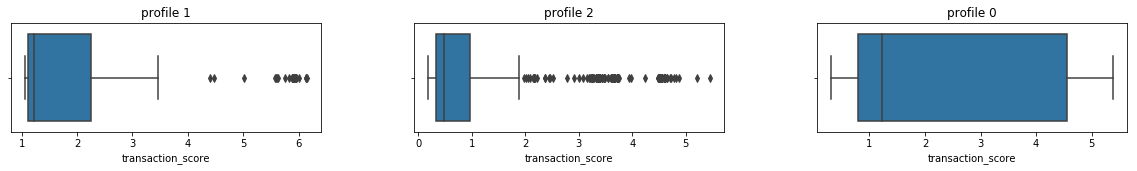

In [54]:
plt.figure(1 , figsize = (20 , 5))
n = 0 
for x in profiles:
    n += 1
    plt.subplot(2 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
    sns.boxplot(x=data[data["cluster_max"]==x]["transaction_score"])


    plt.title( "profile " + str(x) )
plt.show()


In [58]:
# Point on the outliers in each profile
# q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)


In [61]:
# data["risk_is_medium"]=0
# q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)
# cond_q=data[data["cluster_max"]==x]["transaction_score"]>q3
# data["risk_is_medium"]=data["risk_is_medium"].mask(cond_q,1)

In [57]:
data["q3_threshold"]=0

for x in profiles:
    cond_q=data["cluster_max"]==x
    q3=data[data["cluster_max"]==x]["transaction_score"].quantile(0.75)
    data["q3_threshold"]=data["q3_threshold"].mask(cond_q,q3)

In [68]:
np.max(data[data["cluster_max"]==x]["transaction_score"])

3.2787214964854896

In [58]:
data["max_threshold"]=0

for x in profiles:
    cond_max=data["cluster_max"]==x
    maxi=np.max(data[data["cluster_max"]==x]["transaction_score"])
    data["max_threshold"]=data["max_threshold"].mask(cond_max,maxi)

In [59]:
data.head(1)

,BALANCE_AMT,AMOUNT,month,day,dayofweek,quarter,cluster,Account_No,cluster_max,bal_centroid,...,balance_score,amount_score,month_score,day_score,dayofweek_score,quarter_score,transaction_score,is_normal,q3_threshold,max_threshold
0,0.729389,-0.340374,-1.792425,-1.69924,-1.359998,-1.541793,3,409000611074',0,-0.17978,...,0.909169,0.98183,2.49976,1.806078,0.640288,2.288688,9.125813,0,6.233871,11.829509


In [60]:
scores=pd.DataFrame()
scores[["Account_No","cluster_max","balance_score","amount_score","month_score","day_score","dayofweek_score","quarter_score",
        "transaction_score","is_normal","q3_threshold","max_threshold"]]=data[["Account_No","cluster_max","balance_score","amount_score",
                                                                               "month_score","day_score","dayofweek_score","quarter_score",
                                                                                                                                         "transaction_score","is_normal","q3_threshold","max_threshold"]]

In [75]:
scores.to_csv ('transactions_scores_1.1.csv', index = None, header=True)


In [68]:
# clients
data["Account_No"][data["cluster_max"]==5].value_counts()

409000362497'    5352
Name: Account_No, dtype: int64

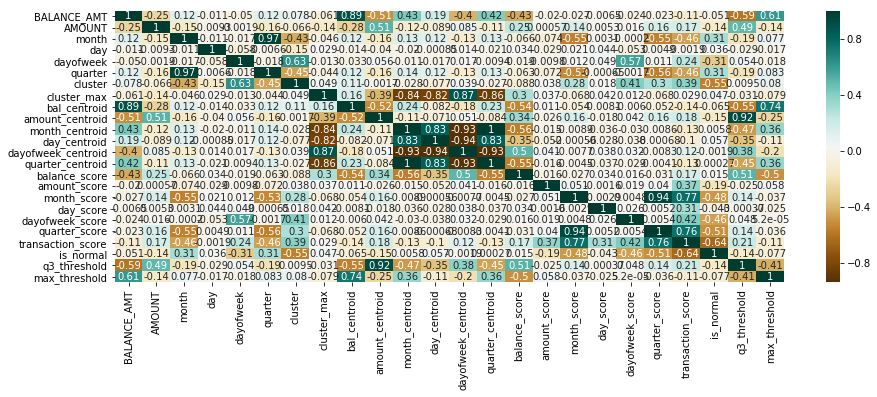

In [69]:
plt.figure(figsize=(15,5))
c= data.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

In [73]:
scores["month_df"]=df["month"]
scores['day_df']=df["day"]

In [74]:
scores.head(1)

,Account_No,cluster_max,balance_score,amount_score,month_score,day_score,dayofweek_score,quarter_score,transaction_score,is_normal,q3_threshold,max_threshold,month_df,day_df
0,409000611074',0,0.909169,0.98183,2.49976,1.806078,0.640288,2.288688,9.125813,0,6.233871,11.829509,1,1
